# Homework Solution 12

Ming Hong (mh4286@nyu.edu)

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Problem 1

* Derive the CFL condition for the Crank-Nicholson method for the Black-Scholes PDE, assuming $r=0$.

### Solution
$\renewcommand{FDut}{\frac{u_{i,k+1}-u_{i,k}}{\triangle t}}
\renewcommand{FDutb}{\frac{u_{i,k}-u_{i,k-1}}{\triangle t}}
\renewcommand{FDutc}{\frac{u_{i,k+1}-u_{i,k-1}}{2\triangle t}}
\renewcommand{FDutt}{\frac{u_{i,k+1}-2u_{i,k}+u_{i,k-1}}{\triangle t^2}}
\renewcommand{FDux}{\frac{u_{i+1,k}-u_{i,k}}{\triangle x}}
\renewcommand{FDuxb}{\frac{u_{i,k}-u_{i-1,k}}{\triangle x}}
\renewcommand{FDuxc}{\frac{u_{i+1,k}-u_{i-1,k}}{2\triangle x}}
\renewcommand{FDuxx}{\frac{u_{i+1,k}-2u_{i,k}+u_{i-1,k}}{\triangle x^2}}$
The discretized Black-Scholes PDE is

\begin{aligned}
\FDut & = \frac{1}{4}  \sigma^2 x_i^2 \left\{ \FDuxx + \frac{u_{i+1,k+1}-2u_{i,k+1}+u_{i-1,k+1}}{\triangle x^2} \right\}
\\ 
    & + \frac{1}{2} r x_i \left\{ \FDuxc + \frac{u_{i+1,k+1}-u_{i-1,k+1}}{2\triangle x} \right\} 
\\
    & - \frac{1}{2} r \left\{  u_{i,k} +  u_{i,k+1} \right\} 
\end{aligned}

Assuming $r=0$, the equation becomes

\begin{aligned}
\FDut & = \frac{1}{4}  \sigma^2 x_i^2 \left\{ \FDuxx + \frac{u_{i+1,k+1}-2u_{i,k+1}+u_{i-1,k+1}}{\triangle x^2} \right\}
\end{aligned}

Substituting in the error $\epsilon_{j,k} = e^{a t_k}e^{il_mx_j}$ for $u_{i,k}$, we have

\begin{aligned}
e^{a t_k+\Delta t} e^{il_m x_j} -e^{a t_k} e^{il_m x_j} & = \frac{1}{4}\sigma^2 x_j^2 \frac{\Delta t}{\Delta x^2} 
\left( e^{a t_k} e^{il_m x_{j+1}} - 2 e^{a t_k} e^{il_mx_j} + e^{a t_k} e^{il_m x_{j-1}} + e^{a t_k+\Delta t} e^{il_m x_{j+1}} - 2e^{a t_k+\Delta t} e^{il_m x_j} + e^{a t_k+\Delta t} e^{il_m x_{j-1}} 
\right)
\\
e^{a\Delta t} - 1 & = \frac{1}{4}\sigma^2 x_j^2 \frac{\Delta t}{\Delta x^2} 
\left( e^{il_m \Delta x} - 2 + e^{-il_m \Delta x} + e^{a\Delta t} e^{il_m \Delta x} - 2e^{a\Delta t} + e^{a\Delta t} e^{-il_m \Delta x} 
\right)
\\
e^{a\Delta t} - 1 & = \frac{1}{4}\sigma^2 x_j^2 \frac{\Delta t}{\Delta x^2} 
\left[ 2\cos{(l_m\Delta x)} - 2 \right]  + \frac{1}{4}\sigma^2 x_j^2 \frac{\Delta t}{\Delta x^2} e^{a\Delta t} \left[ 2\cos{(l_m\Delta x)} - 2 \right]
\\
\Longrightarrow e^{a\Delta t} & = \frac{1+\frac{1}{4}\sigma^2 x_j^2 \frac{\Delta t}{\Delta x^2}\left[ 2\cos{(l_m\Delta x)} - 2 \right]}{1-\frac{1}{4}\sigma^2 x_j^2 \frac{\Delta t}{\Delta x^2}\left[ 2\cos{(l_m\Delta x)} - 2 \right]}
\end{aligned}

Since 

$$\frac{1}{4}\sigma^2 x_j^2 \frac{\Delta t}{\Delta x^2} \ge 0 \;\; \text{and} \;\; 2\cos{(l_m\Delta x)} - 2 \le 0 $$ 

we have $ \Vert e^{a \Delta t} \Vert \le 1$.

Thus, for $r=0$, the Crank-Nicolson scheme is unconditionally stable.

## Problem 2

* Implement the FDM for Black-Scholes PDE using the Crank-Nicolson Scheme and test your code using the same example in Lecture 13 for both the vanilla European Call and the Up-and-out Barrier Call.



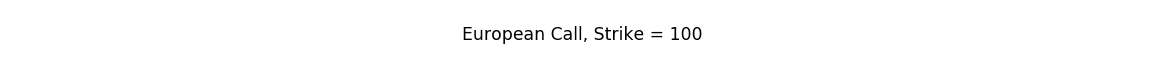

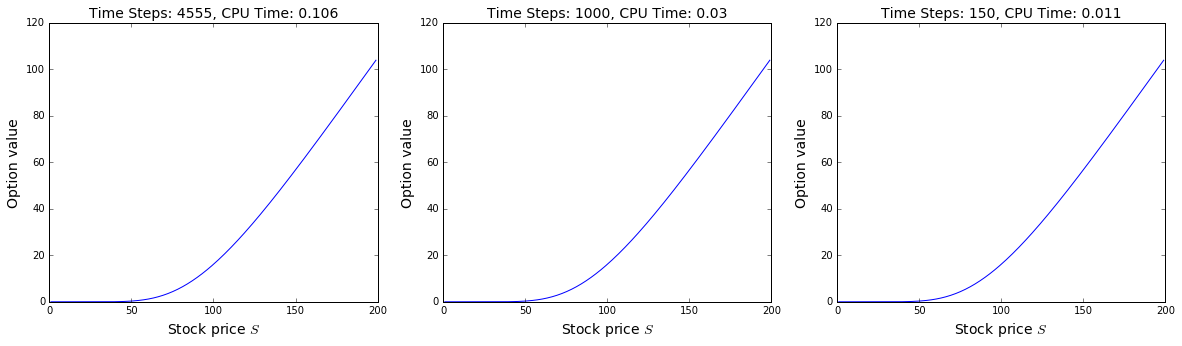

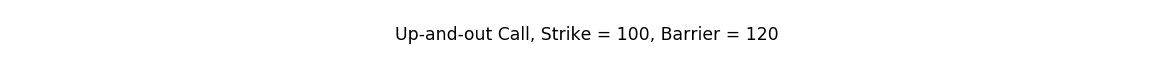

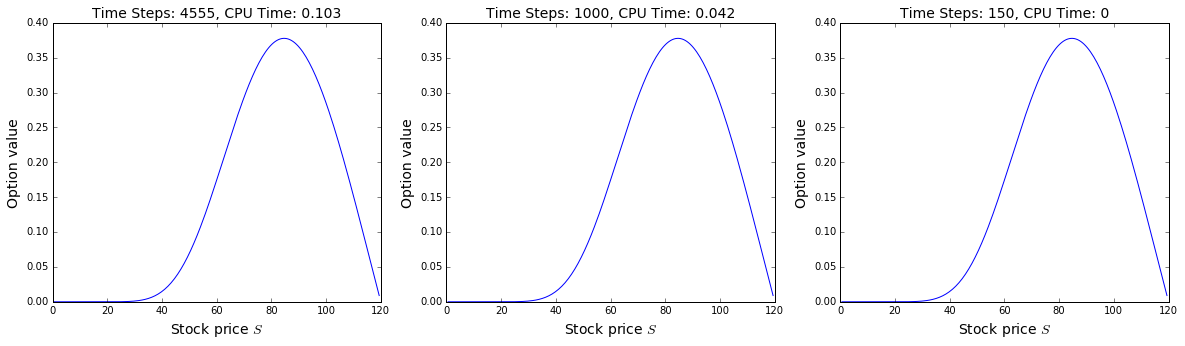

In [3]:
from numpy.core import empty, clip, zeros, exp
from numpy import linspace
import scipy.sparse.linalg.dsolve as linsolve
from scipy import sparse
import matplotlib.pyplot as plt
import time

class BS_FDM_cn:

    def __init__(self, r, sigma, T, Smin, Smax, Fl, Fu, Fp, m, n):
    
        self.r  = r
        self.sigma = sigma
        self.T  = T
    
        self.Smin = Smin
        self.Smax = Smax
        self.Fl = Fl
        self.Fu = Fu
    
        self.m  = m
        self.n  = n
        
        # Step sizes
        self.dt = float(T)/m
        self.dx = float(Smax-Smin)/(n+1)
        self.xs = Smin/self.dx
    
        self.u = empty((m+1, n))
        self.u[0,:] = Fp
    
    def build(self):
    
        A = sparse.lil_matrix((self.n, self.n))
        C = sparse.lil_matrix((self.n, self.n))
    
        for j in xrange(0, self.n):
            xd = j+1+self.xs
            ssxx = (self.sigma * xd) ** 2
        
            A[j,j] = 1.0 - 0.5*self.dt*(ssxx + self.r)
            C[j,j] = 1.0 + 0.5*self.dt*(ssxx + self.r)
            
            if j > 0:
                A[j,j-1] = 0.25*self.dt*(+ssxx - self.r*xd)
                C[j,j-1] = 0.25*self.dt*(-ssxx + self.r*xd)
            if j < self.n-1:
                A[j,j+1] = 0.25*self.dt*(+ssxx + self.r*xd)
                C[j,j+1] = 0.25*self.dt*(-ssxx - self.r*xd)
    
        self.A = A.tocsr()
        self.C = linsolve.splu(C)  # sparse LU decomposition
    
        self.rhs = empty((n, ))
    
    def solve(self):
        
        self.build()

        for i in xrange(0, m):

            # explicit part of time step
            self.rhs[:] = self.A * self.u[i,:]
        
            # Add in the two other boundary conditions
            xdl = 1+self.xs
            xdu = self.n+self.xs
            self.rhs[0] += (self.Fl[i] + self.Fl[i+1] ) * 0.25*self.dt*((self.sigma*xdl)**2 - self.r*xdl)
            self.rhs[self.n-1] += (self.Fu[i] + self.Fu[i+1]) * 0.25*self.dt*((self.sigma*xdu)**2 + self.r*xdu)
            
            # implicit part of time step
            self.u[i+1,:] = self.C.solve(self.rhs)

        return self.u
    
def european_call(r, sigma, T, Smax, m, n, Smin=0.0, barrier=None):
    
    X = linspace(0.0, Smax, n+2)
    X = X[1:-1]
    
    Fp = clip(X-K, 0.0, 1e600)
    
    if barrier is None:
        Fu = Smax - K*exp(-r * linspace(0.0, T, m+1))
        Fl = zeros((m+1, ))
    elif barrier == 'up-and-out':
        Fu = Fl = zeros((m+1,))
    
    bs = BS_FDM_cn(r, sigma, T, Smin, Smax, Fl, Fu, Fp, m, n)
    return X, bs.solve()

def plot_solution(T, X, u):
  
    # Plot of price function at time 0
    plt.plot(X, u[-1,:])
    plt.xlabel('Stock price $S$', fontsize=14)
    plt.ylabel('Option value', fontsize=14)


# Parameters
r = 0.05
sigma = 0.35
K = 100.
T = 1
Smax = 200.
n = 201

fig = plt.figure(figsize=[20, 0.5])
ax = fig.add_subplot(111)
ax.set_axis_off()
ax.text(0.39, 0, 'European Call, Strike = 100', size='xx-large')

plt.figure(figsize=[20,5])
for i,m in enumerate([4555, 1000, 150]):
    plt.subplot(1,3, i+1)    
    t1 = time.time()
    X, u = european_call(r, sigma, T, Smax, m, n)
    t = time.time() - t1
    plot_solution(T, X, u)
    plt.title('Time Steps: %.f, CPU Time: %.3g' % (m, t), fontsize=14)

Smax = 120
fig = plt.figure(figsize=[20, 0.5])
ax = fig.add_subplot(111)
ax.set_axis_off()
ax.text(0.33, 0, 'Up-and-out Call, Strike = 100, Barrier = 120', size='xx-large')
plt.figure(figsize=[20,5])
for i,m in enumerate([4555, 1000, 150]):
    plt.subplot(1,3, i+1)    
    t1 = time.time()
    X, u = european_call(r, sigma, T, Smax, m, n, barrier='up-and-out')
    t = time.time() - t1
    plot_solution(T, X, u)
    plt.title('Time Steps: %.f, CPU Time: %.3g' % (m, t), fontsize=14)

plt.show()